In [1]:
from libs import *
from modelings.modelings_bert import *
from modelings.modelings_roberta import *
from modelings.modelings_gpt2 import *
from modelings.modelings_lstm import *
"""
For evaluate, we use a single random seed, as
the models are trained with 5 different seeds
already.
"""
_ = random.seed(123)
_ = np.random.seed(123)
_ = torch.manual_seed(123)

In [2]:
results = {}
# rerunning the boxes below will only append stuffs to the results.

In [58]:
"""
The following blocks will run CEBaB benchmark in
all the combinations of the following conditions.
"""
grid = {
    "eval_split": ["test"],
    # dev,test
    "control": ["checkpoints"],
    # baseline-random,baseline-blackbox,hdims,layers,ks,approximate,ablation,checkpoints
    "seed": [42],
    # 42, 66, 77
    "h_dim": [192],
    # 1,16,64,128,192
    # 1,16,64,75
    "interchange_layer" : [10],
    # 0,1; 2,4,6,8,10,12
    "class_num": [5],
    "k" : [19684], 
    # 0;10,100,500,1000,3000,6000,9848,19684
    "alpha" : [1.0],
    # 0.0,1.0
    "beta" : [1.0],
    # 0.0,1.0
    "gemma" : [3.0],
    # 0.0,3.0
    "model_arch" : ["bert-base-uncased"],
    # lstm, bert-base-uncased, roberta-base, gpt2
    "lr" : ["8e-05"],
    # 8e-05; 0.001
    "counterfactual_type" : ["true"]
    # approximate,true
}

keys, values = zip(*grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

device = 'cuda:9'
batch_size = 32

In [37]:
i = 0
eval_split=permutations_dicts[i]["eval_split"]
seed=permutations_dicts[i]["seed"]
class_num=permutations_dicts[i]["class_num"]
alpha=permutations_dicts[i]["alpha"]
beta=permutations_dicts[i]["beta"]
gemma=permutations_dicts[i]["gemma"]
h_dim=permutations_dicts[i]["h_dim"]
dataset_type = f'{class_num}-way'
control=permutations_dicts[i]["control"]
model_arch=permutations_dicts[i]["model_arch"]
k=permutations_dicts[i]["k"]
interchange_layer=permutations_dicts[i]["interchange_layer"]
lr=permutations_dicts[i]["lr"]
counterfactual_type=permutations_dicts[i]["counterfactual_type"]

if model_arch == "bert-base-uncased":
    model_path = "BERT"
    model_module = BERTForCEBaB
    explainer_module = CausalProxyModelForBERT
elif model_arch == "roberta-base":
    model_path = "RoBERTa" 
    model_module = RoBERTaForCEBaB
    explainer_module = CausalProxyModelForRoBERTa
elif model_arch == "gpt2":
    model_path = "gpt2"
    model_module = GPT2ForCEBaB
    explainer_module = CausalProxyModelForGPT2
elif model_arch == "lstm":
    model_path = "lstm"
    model_module = LSTMForCEBaB
    explainer_module = CausalProxyModelForLSTM
model_path += f"-{control}"


for j in range(0, 7):
    
    grid_conditions=(
        ("eval_split", eval_split),
        ("control", control),
        ("seed", seed),
        ("h_dim", h_dim),
        ("interchange_layer", interchange_layer),
        ("class_num", class_num),
        ("k", k),
        ("alpha", alpha),
        ("beta", beta),
        ("gemma", gemma),
        ("model_arch", model_arch),
        ("lr", lr),
        ("counterfactual_type", counterfactual_type),
        ("checkpoint", j)
    )
    print("Running for this setting: ", grid_conditions)
    
    blackbox_model_path = f'CEBaB/{model_arch}.CEBaB.sa.'\
                          f'{class_num}-class.exclusive.seed_{seed}'
    cpm_model_path = f'../proxy_training_results/{model_path}/'\
                     f'cebab.alpha.{alpha}.beta.{beta}.gemma.{gemma}.'\
                     f'lr.{lr}.dim.{h_dim}.hightype.{model_arch}.'\
                     f'CEBaB.cls.dropout.0.1.enc.dropout.0.1.counter.type.'\
                     f'{counterfactual_type}.k.{k}.int.layer.{interchange_layer}.'\
                     f'seed_{seed}/checkpoint-{j}'

    # load data from HF
    cebab = datasets.load_dataset(
        'CEBaB/CEBaB', use_auth_token=True,
        cache_dir="../train_cache/"
    )

    train, dev, test = preprocess_hf_dataset_inclusive(
        cebab, verbose=1, dataset_type=dataset_type
    )

    eval_dataset = dev if eval_split == 'dev' else test

    tf_model = model_module(
        blackbox_model_path, 
        device=device, 
        batch_size=batch_size
    )
    explainer = explainer_module(
        blackbox_model_path,
        cpm_model_path, 
        device=device, 
        batch_size=batch_size,
        intervention_h_dim=h_dim,
    )
    
    result_per_example, ATE, CEBaB_metrics, CEBaB_metrics_per_aspect_direction, \
    CEBaB_metrics_per_aspect, CaCE_per_aspect_direction, \
    ACaCE_per_aspect, performance_report = cebab_pipeline(
        tf_model, explainer, 
        train, eval_dataset,
        seed, k, dataset_type=dataset_type, 
        shorten_model_name=False, 
        train_setting="inclusive", 
        approximate=False if counterfactual_type == "true" else True
    )
    
    results[grid_conditions] = (
        result_per_example, ATE, CEBaB_metrics, CEBaB_metrics_per_aspect_direction, \
        CEBaB_metrics_per_aspect, CaCE_per_aspect_direction, \
        ACaCE_per_aspect, performance_report
    )


Running for this setting:  (('eval_split', 'dev'), ('control', 'checkpoints'), ('seed', 42), ('h_dim', 192), ('interchange_layer', 10), ('class_num', 5), ('k', 19684), ('alpha', 1.0), ('beta', 1.0), ('gemma', 3.0), ('model_arch', 'bert-base-uncased'), ('lr', '8e-05'), ('counterfactual_type', 'true'), ('checkpoint', 0))


Using custom data configuration CEBaB--CEBaB-ccd674d249652bd4
Reusing dataset parquet (../train_cache/CEBaB___parquet/CEBaB--CEBaB-ccd674d249652bd4/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/5 [00:00<?, ?it/s]

Dropping no majority reviews: 16.6382% of train_exclusive dataset.
Dropping no majority reviews: 16.03% of train_inclusive dataset.
intervention_h_dim=192


  0%|          | 0/122 [00:00<?, ?it/s]/dfs/user/wuzhengx/tool-chain/anaconda3/lib/python3.7/site-packages/transformers/modeling_utils.py:714: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning
100%|██████████| 122/122 [00:16<00:00,  7.39it/s]


Running for this setting:  (('eval_split', 'dev'), ('control', 'checkpoints'), ('seed', 42), ('h_dim', 192), ('interchange_layer', 10), ('class_num', 5), ('k', 19684), ('alpha', 1.0), ('beta', 1.0), ('gemma', 3.0), ('model_arch', 'bert-base-uncased'), ('lr', '8e-05'), ('counterfactual_type', 'true'), ('checkpoint', 1))


Using custom data configuration CEBaB--CEBaB-ccd674d249652bd4
Reusing dataset parquet (../train_cache/CEBaB___parquet/CEBaB--CEBaB-ccd674d249652bd4/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/5 [00:00<?, ?it/s]

Dropping no majority reviews: 16.6382% of train_exclusive dataset.
Dropping no majority reviews: 16.03% of train_inclusive dataset.
intervention_h_dim=192


100%|██████████| 122/122 [00:16<00:00,  7.31it/s]


Running for this setting:  (('eval_split', 'dev'), ('control', 'checkpoints'), ('seed', 42), ('h_dim', 192), ('interchange_layer', 10), ('class_num', 5), ('k', 19684), ('alpha', 1.0), ('beta', 1.0), ('gemma', 3.0), ('model_arch', 'bert-base-uncased'), ('lr', '8e-05'), ('counterfactual_type', 'true'), ('checkpoint', 2))


Using custom data configuration CEBaB--CEBaB-ccd674d249652bd4
Reusing dataset parquet (../train_cache/CEBaB___parquet/CEBaB--CEBaB-ccd674d249652bd4/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/5 [00:00<?, ?it/s]

Dropping no majority reviews: 16.6382% of train_exclusive dataset.
Dropping no majority reviews: 16.03% of train_inclusive dataset.
intervention_h_dim=192


100%|██████████| 122/122 [00:16<00:00,  7.29it/s]


Running for this setting:  (('eval_split', 'dev'), ('control', 'checkpoints'), ('seed', 42), ('h_dim', 192), ('interchange_layer', 10), ('class_num', 5), ('k', 19684), ('alpha', 1.0), ('beta', 1.0), ('gemma', 3.0), ('model_arch', 'bert-base-uncased'), ('lr', '8e-05'), ('counterfactual_type', 'true'), ('checkpoint', 3))


Using custom data configuration CEBaB--CEBaB-ccd674d249652bd4
Reusing dataset parquet (../train_cache/CEBaB___parquet/CEBaB--CEBaB-ccd674d249652bd4/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/5 [00:00<?, ?it/s]

Dropping no majority reviews: 16.6382% of train_exclusive dataset.
Dropping no majority reviews: 16.03% of train_inclusive dataset.
intervention_h_dim=192


100%|██████████| 122/122 [00:16<00:00,  7.27it/s]


Running for this setting:  (('eval_split', 'dev'), ('control', 'checkpoints'), ('seed', 42), ('h_dim', 192), ('interchange_layer', 10), ('class_num', 5), ('k', 19684), ('alpha', 1.0), ('beta', 1.0), ('gemma', 3.0), ('model_arch', 'bert-base-uncased'), ('lr', '8e-05'), ('counterfactual_type', 'true'), ('checkpoint', 4))


Using custom data configuration CEBaB--CEBaB-ccd674d249652bd4
Reusing dataset parquet (../train_cache/CEBaB___parquet/CEBaB--CEBaB-ccd674d249652bd4/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/5 [00:00<?, ?it/s]

Dropping no majority reviews: 16.6382% of train_exclusive dataset.
Dropping no majority reviews: 16.03% of train_inclusive dataset.
intervention_h_dim=192


100%|██████████| 122/122 [00:16<00:00,  7.28it/s]


Running for this setting:  (('eval_split', 'dev'), ('control', 'checkpoints'), ('seed', 42), ('h_dim', 192), ('interchange_layer', 10), ('class_num', 5), ('k', 19684), ('alpha', 1.0), ('beta', 1.0), ('gemma', 3.0), ('model_arch', 'bert-base-uncased'), ('lr', '8e-05'), ('counterfactual_type', 'true'), ('checkpoint', 5))


Using custom data configuration CEBaB--CEBaB-ccd674d249652bd4
Reusing dataset parquet (../train_cache/CEBaB___parquet/CEBaB--CEBaB-ccd674d249652bd4/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/5 [00:00<?, ?it/s]

Dropping no majority reviews: 16.6382% of train_exclusive dataset.
Dropping no majority reviews: 16.03% of train_inclusive dataset.
intervention_h_dim=192


100%|██████████| 122/122 [00:16<00:00,  7.26it/s]


Running for this setting:  (('eval_split', 'dev'), ('control', 'checkpoints'), ('seed', 42), ('h_dim', 192), ('interchange_layer', 10), ('class_num', 5), ('k', 19684), ('alpha', 1.0), ('beta', 1.0), ('gemma', 3.0), ('model_arch', 'bert-base-uncased'), ('lr', '8e-05'), ('counterfactual_type', 'true'), ('checkpoint', 6))


Using custom data configuration CEBaB--CEBaB-ccd674d249652bd4
Reusing dataset parquet (../train_cache/CEBaB___parquet/CEBaB--CEBaB-ccd674d249652bd4/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/5 [00:00<?, ?it/s]

Dropping no majority reviews: 16.6382% of train_exclusive dataset.
Dropping no majority reviews: 16.03% of train_inclusive dataset.
intervention_h_dim=192


100%|██████████| 122/122 [00:16<00:00,  7.27it/s]


In [38]:
important_keys = [
    "eval_split", "seed", "checkpoint"
]
values = []
for k, v in results.items():
    _values = []
    for ik in important_keys:
        _values.append(dict(k)[ik])
    _values.append(v[2]["ICaCE-L2"].iloc[0])
    _values.append(v[2]["ICaCE-cosine"].iloc[0])
    _values.append(v[2]["ICaCE-normdiff"].iloc[0])
    _values.append(v[-1].iloc[0][0])
    values.append(_values)
important_keys.extend(["ICaCE-L2", "ICaCE-cosine", "ICaCE-normdiff", "macro-f1"])
df = pd.DataFrame(values, columns=important_keys)
df.sort_values(by=['checkpoint'], ascending=True)

,eval_split,seed,checkpoint,ICaCE-L2,ICaCE-cosine,ICaCE-normdiff,macro-f1
0,test,42,0,0.6572,0.4672,0.5410,0.669891
7,dev,42,0,0.6494,0.4744,0.5373,0.669358
1,test,42,1,0.5945,0.4278,0.4539,0.666609
8,dev,42,1,0.5927,0.4499,0.4547,0.649702
2,test,42,2,0.5568,0.4190,0.4115,0.695975
9,dev,42,2,0.5428,0.4295,0.4014,0.702333
3,test,42,3,0.4991,0.3815,0.3641,0.690692
10,dev,42,3,0.4964,0.4061,0.3597,0.691559
4,test,42,4,0.4715,0.3674,0.3174,0.696899
11,dev,42,4,0.4555,0.3832,0.3082,0.696403


In [47]:
def make_single_plot(ax, x, y, y_std, color, marker, ylims, label=None):
    ax.plot(x, y, color=color, marker=marker, markersize=12, label=label)
    ax.set_ylim(ylims[0], ylims[1])
    return ax

In [48]:
dev_df = df[df["eval_split"] == "dev"]
test_df = df[df["eval_split"] == "test"]

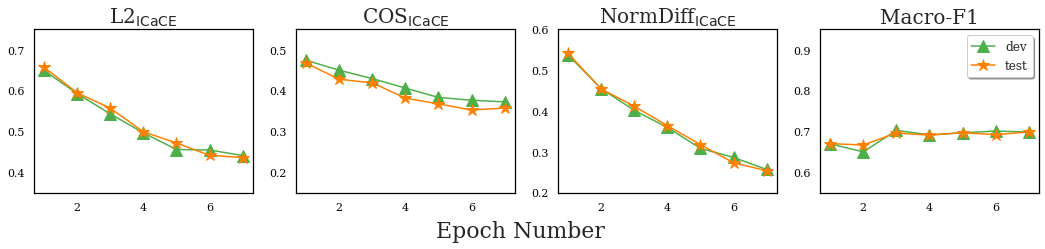

In [53]:
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 20}
plt.rc('font', **font)
items = ["ICaCE-L2", "ICaCE-cosine", "ICaCE-normdiff", "macro-f1"]
x = test_df["checkpoint"]+1
x = x.tolist()

with plt.rc_context({
    'axes.edgecolor':'black', 'xtick.color':'black', 
    'ytick.color':'black', 'axes.facecolor':'white', 
}):
    fig, axs = plt.subplots(1, 4, figsize=(18, 3))
    axs[0].set_title(r'L2$_{\rm ICaCE}$', fontsize=20)
    axs[1].set_title(r'COS$_{\rm ICaCE}$', fontsize=20)
    axs[2].set_title(r'NormDiff$_{\rm ICaCE}$', fontsize=20)
    axs[3].set_title(r'Macro-F1', fontsize=20)
    
    # layers
    ylims_all = [
        [0.35, 0.75],
        [0.15, 0.55],
        [0.20, 0.60],
        [0.55, 0.95]
    ]
    
    # '#377eb8', '#ff7f00', '#4daf4a', '#f781bf'
    
    make_single_plot(
        axs[0], x, dev_df["ICaCE-L2"].tolist(), [], 
        color='#4daf4a', marker="^", ylims=ylims_all[0], label=None
    )
    make_single_plot(
        axs[1], x, dev_df["ICaCE-cosine"].tolist(), [], 
        color='#4daf4a', marker="^", ylims=ylims_all[1], label=None
    )
    make_single_plot(
        axs[2], x, dev_df["ICaCE-normdiff"].tolist(), [], 
        color='#4daf4a', marker="^", ylims=ylims_all[2], label=None
    )
    make_single_plot(
        axs[3], x, dev_df["macro-f1"].tolist(), [], 
        color='#4daf4a', marker="^", ylims=ylims_all[3], label="dev"
    )
    
    make_single_plot(
        axs[0], x, test_df["ICaCE-L2"].tolist(), [], 
        color='#ff7f00', marker="*", ylims=ylims_all[0], label=None
    )
    make_single_plot(
        axs[1], x, test_df["ICaCE-cosine"].tolist(), [], 
        color='#ff7f00', marker="*", ylims=ylims_all[1], label=None
    )
    make_single_plot(
        axs[2], x, test_df["ICaCE-normdiff"].tolist(), [], 
        color='#ff7f00', marker="*", ylims=ylims_all[2], label=None
    )
    make_single_plot(
        axs[3], x, test_df["macro-f1"].tolist(), [], 
        color='#ff7f00', marker="*", ylims=ylims_all[3], label="test"
    )
    
    axs[3].legend(loc='upper right',
                 ncol=1, fancybox=True, shadow=True, fontsize=12, facecolor="white")
        
    _ = fig.text(0.5, -0.08, r'Epoch Number', ha='center', fontsize=22)
    
    plt.subplots_adjust(wspace=0.2, 
                        hspace=0.2)
    plt.savefig("./figures/metrics-epoch.png",dpi=200, bbox_inches='tight')

In [90]:
i = 0
eval_split=permutations_dicts[i]["eval_split"]
seed=permutations_dicts[i]["seed"]
class_num=permutations_dicts[i]["class_num"]
alpha=permutations_dicts[i]["alpha"]
beta=permutations_dicts[i]["beta"]
gemma=permutations_dicts[i]["gemma"]
h_dim=permutations_dicts[i]["h_dim"]
dataset_type = f'{class_num}-way'
control=permutations_dicts[i]["control"]
model_arch=permutations_dicts[i]["model_arch"]
k=permutations_dicts[i]["k"]
interchange_layer=permutations_dicts[i]["interchange_layer"]
lr=permutations_dicts[i]["lr"]
counterfactual_type=permutations_dicts[i]["counterfactual_type"]

if model_arch == "bert-base-uncased":
    model_path = "BERT"
    model_module = BERTForCEBaB
    explainer_module = CausalProxyModelForBERT
elif model_arch == "roberta-base":
    model_path = "RoBERTa" 
    model_module = RoBERTaForCEBaB
    explainer_module = CausalProxyModelForRoBERTa
elif model_arch == "gpt2":
    model_path = "gpt2"
    model_module = GPT2ForCEBaB
    explainer_module = CausalProxyModelForGPT2
elif model_arch == "lstm":
    model_path = "lstm"
    model_module = LSTMForCEBaB
    explainer_module = CausalProxyModelForLSTM
model_path += f"-{control}"

j = 0
grid_conditions=(
    ("eval_split", eval_split),
    ("control", control),
    ("seed", seed),
    ("h_dim", h_dim),
    ("interchange_layer", interchange_layer),
    ("class_num", class_num),
    ("k", k),
    ("alpha", alpha),
    ("beta", beta),
    ("gemma", gemma),
    ("model_arch", model_arch),
    ("lr", lr),
    ("counterfactual_type", counterfactual_type),
    ("checkpoint", j)
)
print("Running for this setting: ", grid_conditions)

blackbox_model_path = f'CEBaB/{model_arch}.CEBaB.sa.'\
                      f'{class_num}-class.exclusive.seed_{seed}'
cpm_model_path = f'../proxy_training_results/{model_path}/'\
                 f'cebab.alpha.{alpha}.beta.{beta}.gemma.{gemma}.'\
                 f'lr.{lr}.dim.{h_dim}.hightype.{model_arch}.'\
                 f'CEBaB.cls.dropout.0.1.enc.dropout.0.1.counter.type.'\
                 f'{counterfactual_type}.k.{k}.int.layer.{interchange_layer}.'\
                 f'seed_{seed}/checkpoint-{j}'

# load data from HF
cebab = datasets.load_dataset(
    'CEBaB/CEBaB', use_auth_token=True,
    cache_dir="../train_cache/"
)

train, dev, test = preprocess_hf_dataset_inclusive(
    cebab, verbose=1, dataset_type=dataset_type
)

eval_dataset = dev if eval_split == 'dev' else test

tf_model = model_module(
    blackbox_model_path, 
    device=device, 
    batch_size=batch_size
)
explainer = explainer_module(
    blackbox_model_path,
    cpm_model_path, 
    device=device, 
    batch_size=batch_size,
    intervention_h_dim=h_dim,
)

Running for this setting:  (('eval_split', 'test'), ('control', 'checkpoints'), ('seed', 42), ('h_dim', 192), ('interchange_layer', 10), ('class_num', 5), ('k', 19684), ('alpha', 1.0), ('beta', 1.0), ('gemma', 3.0), ('model_arch', 'bert-base-uncased'), ('lr', '8e-05'), ('counterfactual_type', 'true'), ('checkpoint', 0))


Using custom data configuration CEBaB--CEBaB-ccd674d249652bd4
Reusing dataset parquet (../train_cache/CEBaB___parquet/CEBaB--CEBaB-ccd674d249652bd4/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/5 [00:00<?, ?it/s]

Dropping no majority reviews: 16.6382% of train_exclusive dataset.
Dropping no majority reviews: 16.03% of train_inclusive dataset.
intervention_h_dim=192


In [71]:
from captum.attr import visualization as viz
import torch.nn.functional as F

In [72]:
#!/usr/bin/env python3
import functools
import warnings
from typing import Any, Callable, List, overload, Tuple, Union

from captum._utils.common import (
    _extract_device,
    _format_additional_forward_args,
    _format_outputs,
)
from captum._utils.gradient import _forward_layer_eval #, _run_forward
#################### IMPORT MODULES ###########################
from inspect import signature
from captum._utils.common import _select_targets, _format_input
###############################################################
from captum._utils.typing import BaselineType, Literal, ModuleOrModuleList, TargetType
from captum.attr._core.integrated_gradients import IntegratedGradients
from captum.attr._utils.attribution import GradientAttribution, LayerAttribution
from captum.attr._utils.common import (
    _format_input_baseline,
    _tensorize_baseline,
    _validate_input,
)
from captum.log import log_usage
from torch import Tensor
from torch.nn.parallel.scatter_gather import scatter

############### A FEW CONSTANTS (SHOULD LATER INTEGRATE AS ARGUMENTS) ####################
INTERVENTION_H_DIM = 192
MODEL_H_DIM = 768
INTERCHANGE_LAYER = interchange_layer
CONTROL = False

####################### OVERRIDE RUN FORWARD FUNCTION ####################################
def _run_forward(
    forward_func: Callable,
    inputs: Union[Tensor, Tuple[Tensor, ...]],
    target: TargetType = None,
    additional_forward_args: Any = None,
) -> Tensor:
    forward_func_args = signature(forward_func).parameters
    if len(forward_func_args) == 0:
        output = forward_func()
        return output if target is None else _select_targets(output, target)

    # make everything a tuple so that it is easy to unpack without
    # using if-statements
    inputs = _format_input(inputs)
    additional_forward_args = _format_additional_forward_args(additional_forward_args)

    output = forward_func(
        *(*inputs, *additional_forward_args)
        if additional_forward_args is not None
        else inputs,
    )
    if CONTROL:
        logits = output.logits # take first logit for overall sentiment
    else:
        logits = output.logits[0] # take first logit for overall sentiment
    final_activation = output.hidden_states[INTERCHANGE_LAYER]
    return _select_targets(logits, target), final_activation
#########################################################################################


class LayerIntegratedGradients(LayerAttribution, GradientAttribution):
    r"""
    Layer Integrated Gradients is a variant of Integrated Gradients that assigns
    an importance score to layer inputs or outputs, depending on whether we
    attribute to the former or to the latter one.

    Integrated Gradients is an axiomatic model interpretability algorithm that
    attributes / assigns an importance score to each input feature by approximating
    the integral of gradients of the model's output with respect to the inputs
    along the path (straight line) from given baselines / references to inputs.

    Baselines can be provided as input arguments to attribute method.
    To approximate the integral we can choose to use either a variant of
    Riemann sum or Gauss-Legendre quadrature rule.

    More details regarding the integrated gradients method can be found in the
    original paper:
    https://arxiv.org/abs/1703.01365

    """

    def __init__(
        self,
        forward_func: Callable,
        layer: ModuleOrModuleList,
        device_ids: Union[None, List[int]] = None,
        multiply_by_inputs: bool = True,
    ) -> None:
        r"""
        Args:
            forward_func (callable):  The forward function of the model or any
                        modification of it
            layer (ModuleOrModuleList):
                        Layer or list of layers for which attributions are computed.
                        For each layer the output size of the attribute matches
                        this layer's input or output dimensions, depending on
                        whether we attribute to the inputs or outputs of the
                        layer, corresponding to the attribution of each neuron
                        in the input or output of this layer.

                        Please note that layers to attribute on cannot be
                        dependent on each other. That is, a subset of layers in
                        `layer` cannot produce the inputs for another layer.

                        For example, if your model is of a simple linked-list
                        based graph structure (think nn.Sequence), e.g. x -> l1
                        -> l2 -> l3 -> output. If you pass in any one of those
                        layers, you cannot pass in another due to the
                        dependence, e.g.  if you pass in l2 you cannot pass in
                        l1 or l3.

            device_ids (list(int)): Device ID list, necessary only if forward_func
                        applies a DataParallel model. This allows reconstruction of
                        intermediate outputs from batched results across devices.
                        If forward_func is given as the DataParallel model itself,
                        then it is not necessary to provide this argument.
            multiply_by_inputs (bool, optional): Indicates whether to factor
                        model inputs' multiplier in the final attribution scores.
                        In the literature this is also known as local vs global
                        attribution. If inputs' multiplier isn't factored in,
                        then this type of attribution method is also called local
                        attribution. If it is, then that type of attribution
                        method is called global.
                        More detailed can be found here:
                        https://arxiv.org/abs/1711.06104

                        In case of layer integrated gradients, if `multiply_by_inputs`
                        is set to True, final sensitivity scores are being multiplied by
                        layer activations for inputs - layer activations for baselines.

        """
        LayerAttribution.__init__(self, forward_func, layer, device_ids=device_ids)
        GradientAttribution.__init__(self, forward_func)
        self.ig = IntegratedGradients(forward_func, multiply_by_inputs)

        if isinstance(layer, list) and len(layer) > 1:
            warnings.warn(
                "Multiple layers provided. Please ensure that each layer is"
                "**not** solely solely dependent on the outputs of"
                "another layer. Please refer to the documentation for more"
                "detail."
            )

    @overload
    def attribute(
        self,
        inputs: Union[Tensor, Tuple[Tensor, ...]],
        baselines: BaselineType,
        target: TargetType,
        additional_forward_args: Any,
        n_steps: int,
        method: str,
        internal_batch_size: Union[None, int],
        return_convergence_delta: Literal[False],
        attribute_to_layer_input: bool,
    ) -> Union[Tensor, Tuple[Tensor, ...], List[Union[Tensor, Tuple[Tensor, ...]]]]:
        ...

    @overload
    def attribute(
        self,
        inputs: Union[Tensor, Tuple[Tensor, ...]],
        baselines: BaselineType,
        target: TargetType,
        additional_forward_args: Any,
        n_steps: int,
        method: str,
        internal_batch_size: Union[None, int],
        return_convergence_delta: Literal[True],
        attribute_to_layer_input: bool,
    ) -> Tuple[
        Union[Tensor, Tuple[Tensor, ...], List[Union[Tensor, Tuple[Tensor, ...]]]],
        Tensor,
    ]:
        ...

    @overload
    def attribute(
        self,
        inputs: Union[Tensor, Tuple[Tensor, ...]],
        baselines: BaselineType = None,
        target: TargetType = None,
        additional_forward_args: Any = None,
        n_steps: int = 50,
        method: str = "gausslegendre",
        internal_batch_size: Union[None, int] = None,
        return_convergence_delta: bool = False,
        attribute_to_layer_input: bool = False,
    ) -> Union[
        Union[Tensor, Tuple[Tensor, ...], List[Union[Tensor, Tuple[Tensor, ...]]]],
        Tuple[
            Union[Tensor, Tuple[Tensor, ...], List[Union[Tensor, Tuple[Tensor, ...]]]],
            Tensor,
        ],
    ]:
        ...

    @log_usage()
    def attribute(
        self,
        inputs: Union[Tensor, Tuple[Tensor, ...]],
        baselines: BaselineType = None,
        target: TargetType = None,
        additional_forward_args: Any = None,
        n_steps: int = 50,
        method: str = "gausslegendre",
        internal_batch_size: Union[None, int] = None,
        return_convergence_delta: bool = False,
        attribute_to_layer_input: bool = False,
        ############## NEW ARGUMENT: ASPECT OF INTEREST ############################
        aspect: Union[int, None] = None
        ############################################################################
    ) -> Union[
        Union[Tensor, Tuple[Tensor, ...], List[Union[Tensor, Tuple[Tensor, ...]]]],
        Tuple[
            Union[Tensor, Tuple[Tensor, ...], List[Union[Tensor, Tuple[Tensor, ...]]]],
            Tensor,
        ],
    ]:
        r"""
        This method attributes the output of the model with given target index
        (in case it is provided, otherwise it assumes that output is a
        scalar) to layer inputs or outputs of the model, depending on whether
        `attribute_to_layer_input` is set to True or False, using the approach
        described above.

        In addition to that it also returns, if `return_convergence_delta` is
        set to True, integral approximation delta based on the completeness
        property of integrated gradients.

        Args:

            inputs (tensor or tuple of tensors):  Input for which layer integrated
                        gradients are computed. If forward_func takes a single
                        tensor as input, a single input tensor should be provided.
                        If forward_func takes multiple tensors as input, a tuple
                        of the input tensors should be provided. It is assumed
                        that for all given input tensors, dimension 0 corresponds
                        to the number of examples, and if multiple input tensors
                        are provided, the examples must be aligned appropriately.
            baselines (scalar, tensor, tuple of scalars or tensors, optional):
                        Baselines define the starting point from which integral
                        is computed and can be provided as:

                        - a single tensor, if inputs is a single tensor, with
                          exactly the same dimensions as inputs or the first
                          dimension is one and the remaining dimensions match
                          with inputs.

                        - a single scalar, if inputs is a single tensor, which will
                          be broadcasted for each input value in input tensor.

                        - a tuple of tensors or scalars, the baseline corresponding
                          to each tensor in the inputs' tuple can be:
                            - either a tensor with matching dimensions to
                              corresponding tensor in the inputs' tuple
                              or the first dimension is one and the remaining
                              dimensions match with the corresponding
                              input tensor.
                            - or a scalar, corresponding to a tensor in the
                              inputs' tuple. This scalar value is broadcasted
                              for corresponding input tensor.

                        In the cases when `baselines` is not provided, we internally
                        use zero scalar corresponding to each input tensor.

                        Default: None
            target (int, tuple, tensor or list, optional):  Output indices for
                        which gradients are computed (for classification cases,
                        this is usually the target class).
                        If the network returns a scalar value per example,
                        no target index is necessary.
                        For general 2D outputs, targets can be either:

                        - a single integer or a tensor containing a single
                          integer, which is applied to all input examples

                        - a list of integers or a 1D tensor, with length matching
                          the number of examples in inputs (dim 0). Each integer
                          is applied as the target for the corresponding example.

                        For outputs with > 2 dimensions, targets can be either:

                        - A single tuple, which contains #output_dims - 1
                          elements. This target index is applied to all examples.

                        - A list of tuples with length equal to the number of
                          examples in inputs (dim 0), and each tuple containing
                          #output_dims - 1 elements. Each tuple is applied as the
                          target for the corresponding example.

                        Default: None
            additional_forward_args (any, optional): If the forward function
                        requires additional arguments other than the inputs for
                        which attributions should not be computed, this argument
                        can be provided. It must be either a single additional
                        argument of a Tensor or arbitrary (non-tuple) type or a
                        tuple containing multiple additional arguments including
                        tensors or any arbitrary python types. These arguments
                        are provided to forward_func in order following the
                        arguments in inputs.
                        For a tensor, the first dimension of the tensor must
                        correspond to the number of examples. It will be
                        repeated for each of `n_steps` along the integrated
                        path. For all other types, the given argument is used
                        for all forward evaluations.
                        Note that attributions are not computed with respect
                        to these arguments.
                        Default: None
            n_steps (int, optional): The number of steps used by the approximation
                        method. Default: 50.
            method (string, optional): Method for approximating the integral,
                        one of `riemann_right`, `riemann_left`, `riemann_middle`,
                        `riemann_trapezoid` or `gausslegendre`.
                        Default: `gausslegendre` if no method is provided.
            internal_batch_size (int, optional): Divides total #steps * #examples
                        data points into chunks of size at most internal_batch_size,
                        which are computed (forward / backward passes)
                        sequentially. internal_batch_size must be at least equal to
                        #examples.
                        For DataParallel models, each batch is split among the
                        available devices, so evaluations on each available
                        device contain internal_batch_size / num_devices examples.
                        If internal_batch_size is None, then all evaluations are
                        processed in one batch.
                        Default: None
            return_convergence_delta (bool, optional): Indicates whether to return
                        convergence delta or not. If `return_convergence_delta`
                        is set to True convergence delta will be returned in
                        a tuple following attributions.
                        Default: False
            attribute_to_layer_input (bool, optional): Indicates whether to
                        compute the attribution with respect to the layer input
                        or output. If `attribute_to_layer_input` is set to True
                        then the attributions will be computed with respect to
                        layer input, otherwise it will be computed with respect
                        to layer output.
                        Note that currently it is assumed that either the input
                        or the output of internal layer, depending on whether we
                        attribute to the input or output, is a single tensor.
                        Support for multiple tensors will be added later.
                        Default: False
            Returns:
                **attributions** or 2-element tuple of **attributions**, **delta**:
                - **attributions** (*tensor*, tuple of *tensors* or tuple of *tensors*):
                        Integrated gradients with respect to `layer`'s inputs or
                        outputs. Attributions will always be the same size and
                        dimensionality as the input or output of the given layer,
                        depending on whether we attribute to the inputs or outputs
                        of the layer which is decided by the input flag
                        `attribute_to_layer_input`.

                        For a single layer, attributions are returned in a tuple if
                        the layer inputs / outputs contain multiple tensors,
                        otherwise a single tensor is returned.

                        For multiple layers, attributions will always be
                        returned as a list. Each element in this list will be
                        equivalent to that of a single layer output, i.e. in the
                        case that one layer, in the given layers, inputs / outputs
                        multiple tensors: the corresponding output element will be
                        a tuple of tensors. The ordering of the outputs will be
                        the same order as the layers given in the constructor.
                - **delta** (*tensor*, returned if return_convergence_delta=True):
                        The difference between the total approximated and true
                        integrated gradients. This is computed using the property
                        that the total sum of forward_func(inputs) -
                        forward_func(baselines) must equal the total sum of the
                        integrated gradient.
                        Delta is calculated per example, meaning that the number of
                        elements in returned delta tensor is equal to the number of
                        of examples in inputs.

            Examples::

                >>> # ImageClassifier takes a single input tensor of images Nx3x32x32,
                >>> # and returns an Nx10 tensor of class probabilities.
                >>> # It contains an attribute conv1, which is an instance of nn.conv2d,
                >>> # and the output of this layer has dimensions Nx12x32x32.
                >>> net = ImageClassifier()
                >>> lig = LayerIntegratedGradients(net, net.conv1)
                >>> input = torch.randn(2, 3, 32, 32, requires_grad=True)
                >>> # Computes layer integrated gradients for class 3.
                >>> # attribution size matches layer output, Nx12x32x32
                >>> attribution = lig.attribute(input, target=3)
        """
        inps, baselines = _format_input_baseline(inputs, baselines)
        _validate_input(inps, baselines, n_steps, method)

        baselines = _tensorize_baseline(inps, baselines)
        additional_forward_args = _format_additional_forward_args(
            additional_forward_args
        )

        def flatten_tuple(tup):
            return tuple(
                sum((list(x) if isinstance(x, (tuple, list)) else [x] for x in tup), [])
            )

        if self.device_ids is None:
            self.device_ids = getattr(self.forward_func, "device_ids", None)

        inputs_layer = _forward_layer_eval(
            self.forward_func,
            inps,
            self.layer,
            device_ids=self.device_ids,
            additional_forward_args=additional_forward_args,
            attribute_to_layer_input=attribute_to_layer_input,
        )

        # if we have one output
        if not isinstance(self.layer, list):
            inputs_layer = (inputs_layer,)

        num_outputs = [1 if isinstance(x, Tensor) else len(x) for x in inputs_layer]
        num_outputs_cumsum = torch.cumsum(
            torch.IntTensor([0] + num_outputs), dim=0  # type: ignore
        )
        inputs_layer = flatten_tuple(inputs_layer)

        baselines_layer = _forward_layer_eval(
            self.forward_func,
            baselines,
            self.layer,
            device_ids=self.device_ids,
            additional_forward_args=additional_forward_args,
            attribute_to_layer_input=attribute_to_layer_input,
        )
        baselines_layer = flatten_tuple(baselines_layer)

        # inputs -> these inputs are scaled
        def gradient_func(
            forward_fn: Callable,
            inputs: Union[Tensor, Tuple[Tensor, ...]],
            target_ind: TargetType = None,
            additional_forward_args: Any = None,
        ) -> Tuple[Tensor, ...]:
            if self.device_ids is None or len(self.device_ids) == 0:
                scattered_inputs = (inputs,)
            else:
                # scatter method does not have a precise enough return type in its
                # stub, so suppress the type warning.
                scattered_inputs = scatter(  # type:ignore
                    inputs, target_gpus=self.device_ids
                )

            scattered_inputs_dict = {
                scattered_input[0].device: scattered_input
                for scattered_input in scattered_inputs
            }

            with torch.autograd.set_grad_enabled(True):

                def layer_forward_hook(
                    module, hook_inputs, hook_outputs=None, layer_idx=0
                ):
                    device = _extract_device(module, hook_inputs, hook_outputs)
                    is_layer_tuple = (
                        isinstance(hook_outputs, tuple)
                        # hook_outputs is None if attribute_to_layer_input == True
                        if hook_outputs is not None
                        else isinstance(hook_inputs, tuple)
                    )

                    if is_layer_tuple:
                        return scattered_inputs_dict[device][
                            num_outputs_cumsum[layer_idx] : num_outputs_cumsum[
                                layer_idx + 1
                            ]
                        ]

                    return scattered_inputs_dict[device][num_outputs_cumsum[layer_idx]]

                hooks = []
                try:

                    layers = self.layer
                    if not isinstance(layers, list):
                        layers = [self.layer]

                    for layer_idx, layer in enumerate(layers):
                        hook = None
                        # TODO:
                        # Allow multiple attribute_to_layer_input flags for
                        # each layer, i.e. attribute_to_layer_input[layer_idx]
                        if attribute_to_layer_input:
                            hook = layer.register_forward_pre_hook(
                                functools.partial(
                                    layer_forward_hook, layer_idx=layer_idx
                                )
                            )
                        else:
                            hook = layer.register_forward_hook(
                                functools.partial(
                                    layer_forward_hook, layer_idx=layer_idx
                                )
                            )

                        hooks.append(hook)

                    output = _run_forward(
                        self.forward_func, tuple(), target_ind, additional_forward_args
                    )
                finally:
                    for hook in hooks:
                        if hook is not None:
                            hook.remove()

                # assert output[0].numel() == 1, (
                #     "Target not provided when necessary, cannot"
                #     " take gradient with respect to multiple outputs."
                # )
                # torch.unbind(forward_out) is a list of scalar tensor tuples and
                # contains batch_size * #steps elements
                # grads = torch.autograd.grad(torch.unbind(output), inputs)

                ##################### TAKE GRADIENT THROUGH ACTIVATION #########################
                model_output, final_layer_activation = output

                # get aspect representation
                if aspect is not None:
                    start_idx = aspect * INTERVENTION_H_DIM
                    end_idx = (aspect+1) * INTERVENTION_H_DIM
                else:
                    start_idx = 0
                    # end_idx = model_output.hidden_states[-1].size(2)
                    end_idx = MODEL_H_DIM

                # compute backwards gradient from output logits to final layer
                final_layer_gradient = torch.autograd.grad(
                    outputs=torch.unbind(model_output),
                    inputs=final_layer_activation,
                    retain_graph=True
                )

                final_layer_gradient = torch.stack(final_layer_gradient).squeeze(0).clone().detach()

                # reset gradients ??

                # compute backwards gradient from final layer to input layer,
                # guided by the gradient from the logits to the final layer
                mask = torch.zeros_like(final_layer_activation)
                mask[:, 0, start_idx:end_idx] = final_layer_gradient[:, 0, start_idx:end_idx]

                grads = torch.autograd.grad(
                    outputs=torch.unbind(final_layer_activation),
                    inputs=inputs,
                    grad_outputs=torch.unbind(mask)
                )
                ###############################################################################

            return grads

        self.ig.gradient_func = gradient_func
        all_inputs = (
            (inps + additional_forward_args)
            if additional_forward_args is not None
            else inps
        )

        attributions = self.ig.attribute.__wrapped__(  # type: ignore
            self.ig,  # self
            inputs_layer,
            baselines=baselines_layer,
            target=target,
            additional_forward_args=all_inputs,
            n_steps=n_steps,
            method=method,
            internal_batch_size=internal_batch_size,
            return_convergence_delta=False,
        )

        # handle multiple outputs
        output: List[Tuple[Tensor, ...]] = [
            tuple(
                attributions[
                    int(num_outputs_cumsum[i]) : int(num_outputs_cumsum[i + 1])
                ]
            )
            for i in range(len(num_outputs))
        ]

        if return_convergence_delta:
            start_point, end_point = baselines, inps
            # computes approximation error based on the completeness axiom
            delta = self.compute_convergence_delta(
                attributions,
                start_point,
                end_point,
                additional_forward_args=additional_forward_args,
                target=target,
            )
            return _format_outputs(isinstance(self.layer, list), output), delta
        return _format_outputs(isinstance(self.layer, list), output)


    def has_convergence_delta(self) -> bool:
        return True

    @property
    def multiplies_by_inputs(self):
        return self.ig.multiplies_by_inputs

In [62]:
def hf_predict_one_proba(text, tokenizer, model):
    input_ids = tokenizer.encode(
        text, add_special_tokens=True, return_tensors='pt').to(model.device)
    model.eval()
    with torch.no_grad():
        logits = model(input_ids).logits
        # case when cpm returns multiple predictions, take the first
        # (corresponding to overall sentiment)
        if isinstance(logits, tuple):
            logits = logits[0]
        preds = F.softmax(logits, dim=1)
    model.train()
    return preds.squeeze(0)


def hf_ig_encodings(text, tokenizer):
    pad_id = tokenizer.pad_token_id
    cls_id = tokenizer.cls_token_id
    sep_id = tokenizer.sep_token_id
    input_ids = tokenizer.encode(text, add_special_tokens=False)
    base_ids = [pad_id] * len(input_ids)
    input_ids = [cls_id] + input_ids + [sep_id]
    base_ids = [cls_id] + base_ids + [sep_id]
    return torch.LongTensor([input_ids]), torch.LongTensor([base_ids])

In [63]:
ASPECTS = ['ambiance', 'food', 'noise', 'service']
asp_to_ind = {
    'overall': None,
    **({a: i for i, a in enumerate(ASPECTS)})
}

In [64]:
def hf_ig_analyses(inputs, targets, tokenizer, model):
    data = []
    for text, true_class in zip(inputs, targets):
        # create visualization for each aspect 
        for aspect, _ in enumerate(ASPECTS):
            score_vis = hf_ig_analysis_one(text, true_class, tokenizer, model, aspect=aspect)
            data.append(score_vis)
    html = viz.visualize_text(data)

def hf_ig_analysis_one(text, true_class, tokenizer, model, device=0, aspect=None):
    # Option to look at different layers:
    # layer = model.roberta.encoder.layer[0]
    # layer = model.roberta.embeddings.word_embeddings
    layer = model.bert.embeddings

    def ig_forward(inputs):
        # logits at first index, cpm returns multiple logits
        # logits = model(inputs).logits
        # return logits[pred_ind] if isinstance(logits, tuple) else logits
        return model(inputs, output_hidden_states=True)

    ig = LayerIntegratedGradients(ig_forward, layer)

    input_ids, base_ids = hf_ig_encodings(text, tokenizer)

    attrs = ig.attribute(
        input_ids.to(model.device),
        base_ids.to(model.device),
        target=true_class,
        return_convergence_delta=False,
        attribute_to_layer_input=False,
        aspect=aspect
    )

    # Summarize and z-score normalize the attributions
    # for each representation in `layer`:
    scores = attrs.sum(dim=-1).squeeze(0)
    scores = (scores - scores.mean()) / scores.norm()
    
    # Intuitive tokens to help with analysis:
    raw_input = tokenizer.convert_ids_to_tokens(input_ids.tolist()[0])
    # RoBERTa-specific clean-up:
    # raw_input = [x.strip("Ġ") for x in raw_input]

    # Predictions for comparisons:
    pred_probs = hf_predict_one_proba(text, tokenizer, model)
    pred_class = pred_probs.argmax()

    score_vis = viz.VisualizationDataRecord(
        word_attributions=scores,
        pred_prob=pred_probs.max(),
        pred_class=pred_class,
        true_class=true_class,
        # override attribution label with aspect label, to make the visualization clearer
        attr_class=ASPECTS[aspect] if aspect is not None else None,
        attr_score=attrs.sum(),
        raw_input_ids=raw_input,
        convergence_score=None)
    
    max_score = max([abs(score) for score in scores.tolist()])
    mag = 1.0/max_score
    word_idx = 0
    latex_str = ""
    for score in scores.tolist():
        sign = "green" if score > 0 else "red"
        color_mag = int(abs(score*mag)*100)
        word = raw_input[word_idx]
        latex_str += "\\colorbox{"+sign+"!"+str(color_mag)+"}{\\strut "+word+"}"
        word_idx += 1
        
    print(latex_str)
    print()
    
    return score_vis

In [91]:
example_sentences = [
    'The music was too loud, and the decorations were tasteless, but they had friendly waiters and delicious pasta'
]

labels = [4]

In [92]:
CONTROL = False
_ = random.seed(seed)
_ = np.random.seed(seed)
_ = torch.manual_seed(seed)
hf_ig_analyses(
    example_sentences, labels, explainer.tokenizer, 
    explainer.cpm_model.model
)

/dfs/user/wuzhengx/tool-chain/anaconda3/lib/python3.7/site-packages/transformers/modeling_utils.py:714: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


\colorbox{green!4}{\strut [CLS]}\colorbox{red!4}{\strut the}\colorbox{red!4}{\strut music}\colorbox{red!23}{\strut was}\colorbox{red!71}{\strut too}\colorbox{red!24}{\strut loud}\colorbox{green!4}{\strut ,}\colorbox{green!5}{\strut and}\colorbox{green!9}{\strut the}\colorbox{green!19}{\strut decorations}\colorbox{red!16}{\strut were}\colorbox{green!14}{\strut taste}\colorbox{red!16}{\strut ##less}\colorbox{red!9}{\strut ,}\colorbox{green!13}{\strut but}\colorbox{green!1}{\strut they}\colorbox{red!13}{\strut had}\colorbox{green!34}{\strut friendly}\colorbox{red!27}{\strut waiter}\colorbox{red!18}{\strut ##s}\colorbox{red!3}{\strut and}\colorbox{green!100}{\strut delicious}\colorbox{green!21}{\strut pasta}\colorbox{green!4}{\strut [SEP]}

\colorbox{red!4}{\strut [CLS]}\colorbox{red!3}{\strut the}\colorbox{green!4}{\strut music}\colorbox{red!9}{\strut was}\colorbox{red!2}{\strut too}\colorbox{green!3}{\strut loud}\colorbox{red!6}{\strut ,}\colorbox{red!3}{\strut and}\colorbox{red!4}{\stru

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,2 (0.93),ambiance,-0.17,"[CLS] the music was too loud , and the decorations were taste ##less , but they had friendly waiter ##s and delicious pasta [SEP]"
4,2 (0.93),food,0.80,"[CLS] the music was too loud , and the decorations were taste ##less , but they had friendly waiter ##s and delicious pasta [SEP]"
4,2 (0.93),noise,-0.26,"[CLS] the music was too loud , and the decorations were taste ##less , but they had friendly waiter ##s and delicious pasta [SEP]"
4,2 (0.93),service,-0.10,"[CLS] the music was too loud , and the decorations were taste ##less , but they had friendly waiter ##s and delicious pasta [SEP]"
